In [ ]:
# run(`conda create --channel conda-forge --channel bioconda --channel defaults --strict-channel-priority --name blast blast`)
# run(`conda create --channel conda-forge --channel bioconda --channel defaults --strict-channel-priority --name taxonkit taxonkit`)

In [ ]:
# don't try and install plotting libraries without this
# can set in ~/.local/share/jupyter/kernels/
@assert ENV["LD_LIBRARY_PATH"] == ""
import Pkg
pkgs = [
    "Revise",
    "DataFrames",
    "uCSV",
    "StatsPlots",
    "StatsBase",
    "FreqTables",
    "Conda",
    "ProgressMeter",
    "PrettyTables",
    "Distances",
    "Statistics",
    "Kmers",
    "Colors"
]
Pkg.add(pkgs)
for pkg in pkgs
    eval(Meta.parse("import $pkg"))
end
import Mycelia

In [ ]:
base_dir = dirname(pwd())
data_dir = joinpath(base_dir, "data")
results_dir = joinpath(data_dir, "results")

# load in metadata
metadata_dir = joinpath(dirname(pwd()), "metadata")

exposome_environmental_data = DataFrames.DataFrame(uCSV.read(
    joinpath(metadata_dir, "metadata_exposome.rds.tsv"),
    delim='\t',
    header=1,
    typedetectrows=300
))

joint_sample_metadata = DataFrames.DataFrame(uCSV.read(
    joinpath(metadata_dir, "exposome/joint_sample_metadata.tsv"),
    delim='\t',
    header=1,
    typedetectrows=300
))

@assert joint_sample_metadata[!, "Library Name"] == joint_sample_metadata[!, "LibraryName"]

joint_metadata = DataFrames.innerjoin(
    joint_sample_metadata,
    exposome_environmental_data,
    on="Library Name" => "samplenames")

sample_directories = joinpath.(data_dir, "SRA", joint_metadata[!, "Run"])

In [ ]:
viral_contigs_by_tool = Dict{String, Dict{String, Set{String}}}()

In [ ]:
joint_genomad_results = DataFrames.DataFrame()
# sample_directory = first(sample_directories)
ProgressMeter.@showprogress for sample_directory in sample_directories
    genomad_virus_summary = joinpath(sample_directory, "genomad", "final.contigs.fastg.gfa_summary", "final.contigs.fastg.gfa_virus_summary.tsv")
    genomad_results = DataFrames.DataFrame(uCSV.read(genomad_virus_summary, delim='\t', header=1, typedetectrows=100)...)
    genomad_results[!, "sample_id"] .= basename(sample_directory)
    append!(joint_genomad_results, genomad_results, promote=true)
end
joint_genomad_results[!, "seq_name"] = string.(joint_genomad_results[!, "seq_name"])
joint_genomad_results

In [ ]:
viral_contigs_by_tool["genomad"] = Dict{String, Set{String}}()
for gdf in DataFrames.groupby(joint_genomad_results, "sample_id")
    sample_id = gdf[1, "sample_id"]
    viral_contigs_by_tool["genomad"][sample_id] = Set()
    for row in DataFrames.eachrow(gdf)
        push!(viral_contigs_by_tool["genomad"][sample_id], row["seq_name"])
    end
end
viral_contigs_by_tool["genomad"]

In [ ]:
blast_task = "megablast"

In [ ]:
db = "nt_viruses"

In [ ]:
# load in metadata
metadata_dir = joinpath(dirname(pwd()), "metadata")

exposome_environmental_data = DataFrames.DataFrame(uCSV.read(
    joinpath(metadata_dir, "metadata_exposome.rds.tsv"),
    delim='\t',
    header=1,
    typedetectrows=300
))

joint_sample_metadata = DataFrames.DataFrame(uCSV.read(
    joinpath(metadata_dir, "exposome/joint_sample_metadata.tsv"),
    delim='\t',
    header=1,
    typedetectrows=300
))

@assert joint_sample_metadata[!, "Library Name"] == joint_sample_metadata[!, "LibraryName"]

joint_metadata = DataFrames.innerjoin(
    joint_sample_metadata,
    exposome_environmental_data,
    on="Library Name" => "samplenames")

run_ids = sort(joint_metadata[!, "Run"])

sample_paths = joinpath.(data_dir, "SRA", run_ids)

In [ ]:
# NCBI host metadata
ncbi_metadata_file = joinpath(dirname(pwd()), "metadata", "NCBI-virus-refseq.transformed.tsv")
ncbi_host_metadata = DataFrames.DataFrame(uCSV.read(ncbi_metadata_file, header=1, delim='\t', encodings=Dict("false" => false, "true" => true)))

# ICTV host metadata
ictv_metadata_file = joinpath(dirname(pwd()), "metadata", "VMR_MSL38_v1 - VMR MSL38 v1.transformed.tsv")
ictv_host_metadata = DataFrames.DataFrame(uCSV.read(ictv_metadata_file, header=1, delim='\t', typedetectrows=100))
ictv_host_metadata = ictv_host_metadata[.!isempty.(ictv_host_metadata[!, "taxid"]), :]
ictv_host_metadata[!, "taxid"] = parse.(Int, ictv_host_metadata[!, "taxid"])

viral_tax_ids = Set(Mycelia.list_subtaxa(10239))

In [ ]:
joint_top_hits = DataFrames.DataFrame()
ProgressMeter.@showprogress for sample_path in sample_paths[1:end]
    sample = basename(sample_path)
    blastn_directory = mkpath(joinpath(sample_path, "blastn"))
    assembled_fasta = joinpath(sample_path, "megahit", "final.contigs.fastg.gfa.fna")
    blast_file = joinpath(blastn_directory, basename(assembled_fasta) * ".blastn.$(db).$(blast_task).txt")
    this_blast_table = Mycelia.parse_blast_report(blast_file)
    if isempty(this_blast_table)
        continue
    else
        this_blast_table[!, "sample_id"] .= sample
        # bonferonni correction on raw tests
        this_blast_table[!, "evalue"] = this_blast_table[!, "evalue"] .* DataFrames.nrow(this_blast_table)
        
        # filter to top hits to avoid ballooning memory just to throw it away later
        this_top_hits = DataFrames.DataFrame()
        for gdf in DataFrames.groupby(this_blast_table, "query id")
            push!(this_top_hits, first(sort(gdf, "bit score", rev=true)))
        end
        append!(joint_top_hits, this_top_hits)
    end
end

In [ ]:
taxids = unique(joint_top_hits[!, "subject tax id"])
taxid2name_map = Dict(row["taxid"] => row["tax_name"] for row in DataFrames.eachrow(Mycelia.taxids2lineage_name_and_rank(taxids)))
joint_top_hits[!, "subject tax name"] = map(taxid -> taxid2name_map[taxid], joint_top_hits[!, "subject tax id"])

# filter to good hits even after bonferroni correction
joint_top_hits = joint_top_hits[joint_top_hits[!, "evalue"] .<= 0.001, :]

# filter to viral only
viral_hits_df = joint_top_hits[map(x -> x in viral_tax_ids, joint_top_hits[!, "subject tax id"]), :]

# # current_host = "host_is_vertebrate"
# # current_host = "host_is_mammal"
# # current_host = "host_is_primate"
# current_host = "host_is_human"
# host_viral_tax_ids = Set(ncbi_host_metadata[ncbi_host_metadata[!, current_host] .== true, "taxid"])

# # host_viral_taxids = ictv_host_metadata[map(x -> x in ["vertebrates", "invertebrates, vertebrates"], ictv_host_metadata[!, "Host source"]), "taxid"]
# host_hits_df = viral_hits_df[map(x -> x in host_viral_tax_ids, viral_hits_df[!, "subject tax id"]), :]

# blast_viral_contigs = Dict{String, Set{String}}()
# for gdf in DataFrames.groupby(viral_hits_df, "sample_id")
#     sample_id = gdf[1, "sample_id"]
#     blast_viral_contigs[sample_id] = Set()
#     for row in DataFrames.eachrow(gdf)
#         push!(blast_viral_contigs[sample_id], row["query id"])
#     end
# end
# blast_viral_contigs

viral_contigs_by_tool["blast"] = Dict{String, Set{String}}()
for gdf in DataFrames.groupby(viral_hits_df, "sample_id")
    sample_id = gdf[1, "sample_id"]
    viral_contigs_by_tool["blast"][sample_id] = Set()
    for row in DataFrames.eachrow(gdf)
        push!(viral_contigs_by_tool["blast"][sample_id], row["query id"])
    end
end
viral_contigs_by_tool["blast"]

In [ ]:
db = "UniRef50"
uniref50_df = DataFrames.DataFrame()
ProgressMeter.@showprogress for sample_path in sample_paths
    sample_id = basename(sample_path)
    mmseqs_lca_file = joinpath(sample_path, "mmseqs_easy_taxonomy", "final.contigs.fastg.gfa.fna.mmseqs_easy_taxonomy.$(db)_lca.tsv")
    mmseqs_lca_table = Mycelia.parse_mmseqs_easy_taxonomy_lca_tsv(mmseqs_lca_file)
    mmseqs_lca_table[!, "sample_id"] .= sample_id
    append!(uniref50_df, mmseqs_lca_table)
end
uniref50_df
uniref50_viral_df = uniref50_df[map(x -> x in viral_tax_ids, uniref50_df[!, "taxon_id"]), :]

viral_contigs_by_tool[db] = Dict{String, Set{String}}()
for gdf in DataFrames.groupby(uniref50_viral_df, "sample_id")
    sample_id = gdf[1, "sample_id"]
    viral_contigs_by_tool[db][sample_id] = Set()
    for row in DataFrames.eachrow(gdf)
        push!(viral_contigs_by_tool[db][sample_id], string(row["contig_id"]))
    end
end
viral_contigs_by_tool[db]

In [ ]:
db = "UniRef90"
uniref90_df = DataFrames.DataFrame()

ProgressMeter.@showprogress for sample_path in sample_paths
    sample_id = basename(sample_path)
    mmseqs_lca_file = joinpath(sample_path, "mmseqs_easy_taxonomy", "final.contigs.fastg.gfa.fna.mmseqs_easy_taxonomy.$(db)_lca.tsv")
    mmseqs_lca_table = Mycelia.parse_mmseqs_easy_taxonomy_lca_tsv(mmseqs_lca_file)
    mmseqs_lca_table[!, "sample_id"] .= sample_id
    append!(uniref90_df, mmseqs_lca_table)
end
uniref90_df
uniref90_viral_df = uniref90_df[map(x -> x in viral_tax_ids, uniref90_df[!, "taxon_id"]), :]

viral_contigs_by_tool[db] = Dict{String, Set{String}}()
for gdf in DataFrames.groupby(uniref90_viral_df, "sample_id")
    sample_id = gdf[1, "sample_id"]
    viral_contigs_by_tool[db][sample_id] = Set()
    for row in DataFrames.eachrow(gdf)
        push!(viral_contigs_by_tool[db][sample_id], string(row["contig_id"]))
    end
end
viral_contigs_by_tool[db]

In [ ]:
db = "UniRef100"
uniref100_df = DataFrames.DataFrame()

ProgressMeter.@showprogress for sample_path in sample_paths
    sample_id = basename(sample_path)
    mmseqs_lca_file = joinpath(sample_path, "mmseqs_easy_taxonomy", "final.contigs.fastg.gfa.fna.mmseqs_easy_taxonomy.$(db)_lca.tsv")
    mmseqs_lca_table = Mycelia.parse_mmseqs_easy_taxonomy_lca_tsv(mmseqs_lca_file)
    mmseqs_lca_table[!, "sample_id"] .= sample_id
    append!(uniref100_df, mmseqs_lca_table)
end
uniref100_df
uniref100_viral_df = uniref100_df[map(x -> x in viral_tax_ids, uniref100_df[!, "taxon_id"]), :]

viral_contigs_by_tool[db] = Dict{String, Set{String}}()
for gdf in DataFrames.groupby(uniref100_viral_df, "sample_id")
    sample_id = gdf[1, "sample_id"]
    viral_contigs_by_tool[db][sample_id] = Set()
    for row in DataFrames.eachrow(gdf)
        push!(viral_contigs_by_tool[db][sample_id], string(row["contig_id"]))
    end
end
viral_contigs_by_tool[db]

In [ ]:
viral_contigs_by_tool

In [ ]:
ordered_tools = 
["genomad",
"blast",
"UniRef50",
"UniRef90",
"UniRef100"]

ordered_samples = basename.(sample_paths)

In [ ]:
jaccard_similarity(a, b) = length(intersect(a, b)) / length(union(a, b))

In [ ]:
jaccard_similarity_matrix = Array{Union{Missing, Float64}}(missing, length(ordered_tools), length(ordered_tools), length(ordered_samples))
for (x, tool1) in enumerate(ordered_tools)
    for (y, tool2) in enumerate(ordered_tools)
        for (z, sample_id) in enumerate(ordered_samples)
            try
                a = viral_contigs_by_tool[tool1][sample_id]
                b = viral_contigs_by_tool[tool2][sample_id]
                jaccard_similarity_matrix[x, y, z] = jaccard_similarity(a, b)
            catch
                # @show tool1, tool2, sample_id
                continue
            end
        end
    end
end
jaccard_similarity_matrix

In [ ]:
jaccard_similarity_matrix_means = zeros(length(ordered_tools), length(ordered_tools))
jaccard_similarity_matrix_medians = zeros(length(ordered_tools), length(ordered_tools))
jaccard_similarity_matrix_stddevs = zeros(length(ordered_tools), length(ordered_tools))

for x in 1:size(jaccard_similarity_matrix, 1)
    for y in 1:size(jaccard_similarity_matrix, 1)
        non_missing_values = filter(!ismissing, jaccard_similarity_matrix[x, y, :])
        jaccard_similarity_matrix_means[x, y] = Statistics.mean(non_missing_values)
        jaccard_similarity_matrix_medians[x, y] = Statistics.median(non_missing_values)
        jaccard_similarity_matrix_stddevs[x, y] = Statistics.std(non_missing_values)
    end
end

In [ ]:
hits_by_tool_per_sample = Dict{String, Vector{Int}}()
for tool in ordered_tools
    hits_by_tool_per_sample[tool] = Int[length(viral_contigs_by_tool[tool][sample]) for sample in keys(viral_contigs_by_tool[tool])]
end     

In [ ]:
hits_by_tool_per_sample

In [ ]:
p = StatsPlots.plot(
    ordered_tools,
    [Statistics.mean(hits_by_tool_per_sample[tool]) for tool in ordered_tools],
    yerror = [Statistics.std(hits_by_tool_per_sample[tool]) for tool in ordered_tools],
    legend=false,
    title = "mean +/- stddev # viral contigs classified by tool\nacross samples",
    ylabel = "value",
    xlabel = "tool",
    size = (720, 540),
    margins = 10StatsPlots.Plots.PlotMeasures.mm
)
StatsPlots.savefig(p, joinpath(data_dir, "results", "classification-agreement.total-viral-contigs.png"))
p

In [ ]:
hits_by_tool_per_sample

p = StatsPlots.heatmap(
    jaccard_similarity_matrix_means,
    yticks = (1:length(ordered_tools), ordered_tools),
    xticks = (1:length(ordered_tools), ordered_tools),
    title = "Mean Jaccard Similarity",
    xlabel = "tool/database",
    ylabel = "tool/database",
    size = (720, 540),
    margins = 5StatsPlots.Plots.PlotMeasures.mm
)
StatsPlots.savefig(p, joinpath(data_dir, "results", "classification-agreement.mean-jaccard.png"))
p

In [ ]:
p = StatsPlots.heatmap(
    jaccard_similarity_matrix_stddevs,
    yticks = (1:length(ordered_tools), ordered_tools),
    xticks = (1:length(ordered_tools), ordered_tools),
    title = "Standard Deviation of Jaccard Similarity",
    xlabel = "tool/database",
    ylabel = "tool/database",
    size = (720, 540),
    margins = 5StatsPlots.Plots.PlotMeasures.mm
)
StatsPlots.savefig(p, joinpath(data_dir, "results", "classification-agreement.std-jaccard.png"))
p

In [ ]:
unanimous_hits = Dict{String, Set{String}}()
for sample in ordered_samples
    unanimous_hits[sample] = Set(viral_contigs_by_tool["genomad"][sample])
    for other_tool in setdiff(ordered_tools, "genomad")
        # @show other_tool
        unanimous_hits[sample] = intersect(unanimous_hits[sample], viral_contigs_by_tool["genomad"][sample])
    end
end
unanimous_hits

In [ ]:
unanimous_blast_hits = viral_hits_df[[row["query id"] in unanimous_hits[row["sample_id"]] for row in DataFrames.eachrow(viral_hits_df)], :]

current_host = "host_is_human"
# current_host = "host_is_primate"
# current_host = "host_is_mammal"
# current_host = "host_is_vertebrate"
host_viral_tax_ids = Set(ncbi_host_metadata[ncbi_host_metadata[!, current_host] .== true, "taxid"])
unanimous_blast_host_hits = unanimous_blast_hits[map(x -> x in host_viral_tax_ids, unanimous_blast_hits[!, "subject tax id"]), :]
ft = FreqTables.freqtable(unanimous_blast_host_hits, "sample_id", "subject tax name")
data = [collect(keys(ft.dicts[1])), [col for col in eachcol(ft.array)]...]
header = ["$(ft.dimnames[1]) \\ $(ft.dimnames[2])", collect(keys(ft.dicts[2]))...]
summary_table = DataFrames.DataFrame(data, header)
summary_table = DataFrames.innerjoin(summary_table, joint_metadata[!, ["Run", "aownership", "geo_loc_name", "date.end"]], on="sample_id \\ subject tax name" => "Run")
summary_table = summary_table[!, [
    ["sample_id \\ subject tax name", "aownership", "geo_loc_name", "date.end"]...,
    setdiff(names(summary_table), ["sample_id \\ subject tax name", "aownership", "geo_loc_name", "date.end"])...]]
DataFrames.rename!(
    summary_table,
    ["aownership" => "participant", "geo_loc_name" => "location", "date.end" => "collection date"]
)
summary_table
uCSV.write(joinpath(results_dir, "unanimous.ncbi-human-blast-hits.tsv"), delim='\t', summary_table)
summary_table

In [ ]:
# ictv_taxid2host = Dict(row["taxid"] => row["Host source"] for row in DataFrames.eachrow(ictv_host_metadata))
# unique_ictv_hosts = unique(sort(ictv_host_metadata[!, "Host source"]))
# ictv_host2index = Dict(h => i for (i, h) in enumerate(unique_ictv_hosts))

# # ictv_host_metadata

# # unanimous_blast_hits[!, "subject tax id"]

# # xs = [Int[] for i in 1:length(unique_ictv_hosts)+1]
# # ys = [Float64[] for i in 1:length(unique_ictv_hosts)+1]
# # for row in DataFrames.eachrow(unanimous_blast_hits)
# #     if haskey(ictv_taxid2host, row["subject tax id"])
# #         host = ictv_taxid2host[row["subject tax id"]]
# #         idx = ictv_host2index[host]
# #     else
# #         idx = length(ictv_host2index)+1
# #     end
# #     push!(xs[idx], row["alignment length"])
# #     push!(ys[idx], row["% identity"])
# # end

# # colorscheme = Colors.distinguishable_colors(length(unique_ictv_hosts)+1, [Colors.RGB(1,1,1), Colors.RGB(0,0,0)], dropseed=true)

In [ ]:
ncbi_taxid2host = Dict()
for row in DataFrames.eachrow(ncbi_host_metadata)
    taxid = row["taxid"]
    if row["host_is_human"]
        ncbi_taxid2host[taxid] = "human"
    elseif row["host_is_primate"]
        ncbi_taxid2host[taxid] = "primate"
    elseif row["host_is_mammal"]
        ncbi_taxid2host[taxid] = "mammal"
    elseif row["host_is_vertebrate"]
        ncbi_taxid2host[taxid] = "vertebrate"
    else
        ncbi_taxid2host[taxid] = "other"
    end
end
ncbi_taxid2host

ordered_hosts = [
 "human",
 "primate",
"mammal",
 "vertebrate",
 "other",
"unknown"
]

ncbi_host2index = Dict(h => i for (i, h) in enumerate(ordered_hosts))

xs = [Int[] for i in 1:length(ordered_hosts)]
ys = [Float64[] for i in 1:length(ordered_hosts)]
for row in DataFrames.eachrow(unanimous_blast_hits)
    if haskey(ncbi_taxid2host, row["subject tax id"])
        host = ncbi_taxid2host[row["subject tax id"]]
        idx = ncbi_host2index[host]
    else
        idx = length(ordered_hosts)
    end
    push!(xs[idx], row["alignment length"])
    push!(ys[idx], row["% identity"])
end

colorscheme = Colors.distinguishable_colors(length(ordered_hosts), [Colors.RGB(1,1,1), Colors.RGB(0,0,0)], dropseed=true)

p = StatsPlots.scatter(
    # unanimous_blast_hits[!, "alignment length"],
    # unanimous_blast_hits[!, "% identity"],
    reverse(xs),
    reverse(ys),
    title = "Blast alignment quality for unanimous viral contigs",
    xlabel = "alignment length",
    ylabel = "% identity",
    # legend=false,
    margins = 10StatsPlots.Plots.PlotMeasures.mm,
    size = (1080, 720),
    # alpha = 0.7,
    labels = hcat(reverse(ordered_hosts)...),
    seriescolor = hcat(reverse(colorscheme)...),
)
StatsPlots.savefig(p, joinpath(data_dir, "results", "classification-agreement.blast-alignment-quality-for-unaminous-viral-contigs.png"))
p

In [140]:
unanimous_with_ictv = DataFrames.leftjoin(unanimous_blast_hits, ictv_host_metadata, on="subject tax id" => "taxid")
unanimous_with_ictv[!, "Host source"] = map(x -> ismissing(x) ? "unknown" : x, unanimous_with_ictv[!, "Host source"])
unanimous_with_ictv
# ft = FreqTables.freqtable(unanimous_with_ictv, "sample_id", "Host source")
# data = [collect(keys(ft.dicts[1])), [col for col in eachcol(ft.array)]...]
# header = ["$(ft.dimnames[1]) \\ $(ft.dimnames[2])", collect(keys(ft.dicts[2]))...]

Row,query id,subject id,subject acc.,subject acc.ver,subject title,query length,subject length,q. start,q. end,s. start,s. end,evalue,bit score,alignment length,% identity,identical,mismatches,subject tax id,subject tax ids,sample_id,subject tax name,Sort,Isolate Sort,Realm,Subrealm,Kingdom,Subkingdom,Phylum,Subphylum,Class,Subclass,Order,Suborder,Family,Subfamily,Genus,Subgenus,Species,Exemplar or additional isolate,Virus name(s),Virus name abbreviation(s),Virus isolate designation,Virus GENBANK accession,Virus REFSEQ accession,Genome coverage,Genome composition,Host source
,String,String,String,String,String,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Int64,Float64,Int64,Int64,Int64,String,String,String,Int64?,Int64?,String?,String?,String?,String?,String?,String?,String?,String?,String?,String?,String?,String?,String?,String?,String?,String?,String?,String?,String?,String?,String?,String?,String?,String
1,12312,gi|1428093856|gb|MH378442.1|,MH378442,MH378442.1,"Sinsheimervirus phiX174 strain evolved J2 line, complete genome",306,5386,1,306,2226,1921,3.46518e-148,549.0,306,99.02,303,3,10847,10847,SRR6399461,Sinsheimervirus phiX174,4360,1,Monodnaviria,,Sangervirae,,Phixviricota,,Malgrandaviricetes,,Petitvirales,,Microviridae,Bullavirinae,Sinsheimervirus,,Sinsheimervirus phiX174,E,Escherichia phage phiX174,,,J02482,NC_001422,Complete genome,ssDNA,bacteria
2,14090,gi|1428093856|gb|MH378442.1|,MH378442,MH378442.1,"Sinsheimervirus phiX174 strain evolved J2 line, complete genome",260,5386,1,260,2077,1818,4.98212e-121,459.0,260,98.462,256,4,10847,10847,SRR6399461,Sinsheimervirus phiX174,4360,1,Monodnaviria,,Sangervirae,,Phixviricota,,Malgrandaviricetes,,Petitvirales,,Microviridae,Bullavirinae,Sinsheimervirus,,Sinsheimervirus phiX174,E,Escherichia phage phiX174,,,J02482,NC_001422,Complete genome,ssDNA,bacteria
3,6086,gi|1428093856|gb|MH378442.1|,MH378442,MH378442.1,"Sinsheimervirus phiX174 strain evolved J2 line, complete genome",265,5386,1,265,1796,2060,1.81438e-125,473.0,265,98.868,262,3,10847,10847,SRR6399461,Sinsheimervirus phiX174,4360,1,Monodnaviria,,Sangervirae,,Phixviricota,,Malgrandaviricetes,,Petitvirales,,Microviridae,Bullavirinae,Sinsheimervirus,,Sinsheimervirus phiX174,E,Escherichia phage phiX174,,,J02482,NC_001422,Complete genome,ssDNA,bacteria
4,7309,gi|1428093868|gb|MH378443.1|,MH378443,MH378443.1,"Sinsheimervirus phiX174 strain evolved J1, complete genome",281,5386,170,281,2881,2770,5.38613e-38,185.0,112,96.429,108,4,10847,10847,SRR6399486,Sinsheimervirus phiX174,4360,1,Monodnaviria,,Sangervirae,,Phixviricota,,Malgrandaviricetes,,Petitvirales,,Microviridae,Bullavirinae,Sinsheimervirus,,Sinsheimervirus phiX174,E,Escherichia phage phiX174,,,J02482,NC_001422,Complete genome,ssDNA,bacteria
5,28422,gi|2621012958|dbj|LC786485.1|,LC786485,LC786485.1,"MAG: Sinsheimervirus phiX174 DNA, complete genome",5527,5386,558,5527,1,4970,0.0,9178.0,4970,100.0,4970,0,10847,10847,SRR6399487,Sinsheimervirus phiX174,4360,1,Monodnaviria,,Sangervirae,,Phixviricota,,Malgrandaviricetes,,Petitvirales,,Microviridae,Bullavirinae,Sinsheimervirus,,Sinsheimervirus phiX174,E,Escherichia phage phiX174,,,J02482,NC_001422,Complete genome,ssDNA,bacteria
6,61661,gi|2621012958|dbj|LC786485.1|,LC786485,LC786485.1,"MAG: Sinsheimervirus phiX174 DNA, complete genome",5527,5386,1,5178,5178,1,0.0,9563.0,5178,100.0,5178,0,10847,10847,SRR6399491,Sinsheimervirus phiX174,4360,1,Monodnaviria,,Sangervirae,,Phixviricota,,Malgrandaviricetes,,Petitvirales,,Microviridae,Bullavirinae,Sinsheimervirus,,Sinsheimervirus phiX174,E,Escherichia phage phiX174,,,J02482,NC_001422,Complete genome,ssDNA,bacteria
7,89193,gi|2621012958|dbj|LC786485.1|,LC786485,LC786485.1,"MAG: Sinsheimervirus phiX174 DNA, complete genome",5527,5386,1,4993,394,5386,0.0,9221.0,4993,100.0,4993,0,10847,10847,SRR6399492,Sinsheimervirus phiX174,4360,1,Monodnaviria,,Sangervirae,,Phixviricota,,Malgrandaviricetes,,Petitvirales,,Microviridae,Bullavirinae,Sinsheimervirus,,Sinsheimervirus phiX174,E,Escheric

7-element Vector{String}:
 "bacteria"
 "fungi"
 "invertebrates"
 "invertebrates, vertebrates"
 "protists"
 "unknown"
 "vertebrates"

In [144]:
ordered_hosts = sort(unique(unanimous_with_ictv[!, "Host source"]))

7-element Vector{String}:
 "bacteria"
 "fungi"
 "invertebrates"
 "invertebrates, vertebrates"
 "protists"
 "unknown"
 "vertebrates"

In [145]:
ordered_hosts = sort(unique(unanimous_with_ictv[!, "Host source"]))
ictv_host2index = Dict(h => i for (i, h) in enumerate(ordered_hosts))

Dict{String, Int64} with 7 entries:
  "invertebrates, vertebrates" => 4
  "protists"                   => 5
  "bacteria"                   => 1
  "invertebrates"              => 3
  "unknown"                    => 6
  "fungi"                      => 2
  "vertebrates"                => 7

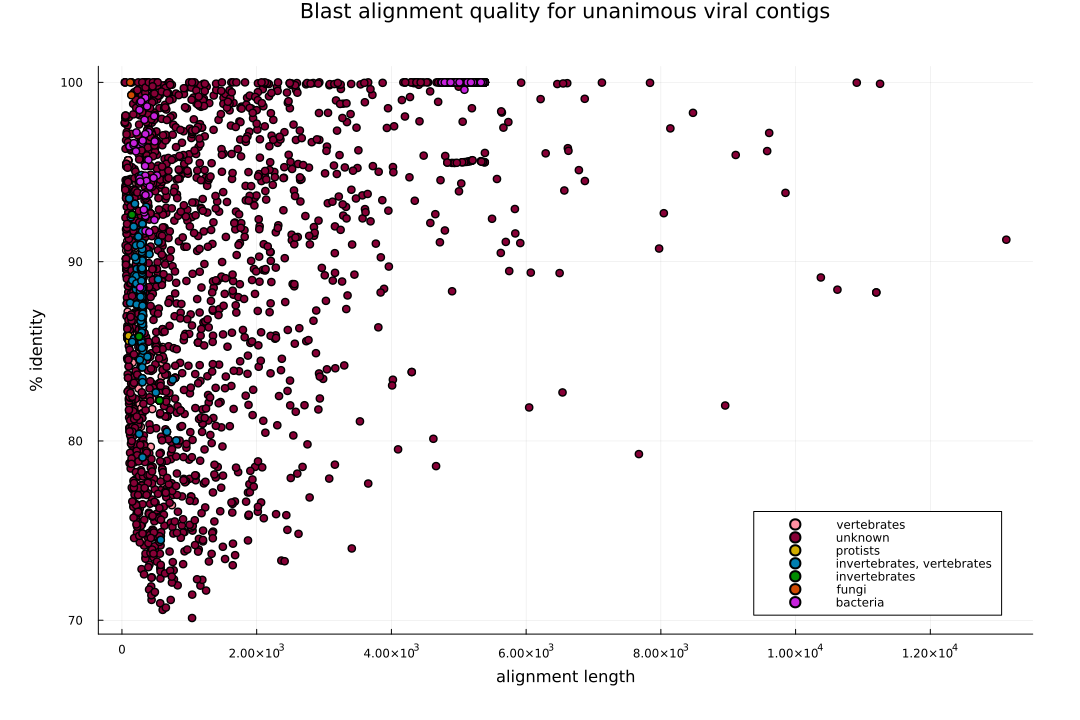

In [146]:
ordered_hosts = sort(unique(unanimous_with_ictv[!, "Host source"]))
ictv_host2index = Dict(h => i for (i, h) in enumerate(ordered_hosts))

xs = [Int[] for i in 1:length(ordered_hosts)]
ys = [Float64[] for i in 1:length(ordered_hosts)]
for row in DataFrames.eachrow(unanimous_with_ictv)
    host = row["Host source"]
    idx = ictv_host2index[host]
    push!(xs[idx], row["alignment length"])
    push!(ys[idx], row["% identity"])
end

colorscheme = Colors.distinguishable_colors(length(ordered_hosts), [Colors.RGB(1,1,1), Colors.RGB(0,0,0)], dropseed=true)

p = StatsPlots.scatter(
    # unanimous_blast_hits[!, "alignment length"],
    # unanimous_blast_hits[!, "% identity"],
    reverse(xs),
    reverse(ys),
    title = "Blast alignment quality for unanimous viral contigs",
    xlabel = "alignment length",
    ylabel = "% identity",
    # legend=false,
    margins = 10StatsPlots.Plots.PlotMeasures.mm,
    size = (1080, 720),
    # alpha = 0.7,
    labels = hcat(reverse(ordered_hosts)...),
    seriescolor = hcat(reverse(colorscheme)...),
)
StatsPlots.savefig(p, joinpath(data_dir, "results", "classification-agreement.blast-alignment-quality-for-unaminous-viral-contigs.ictv.png"))
p